In [1]:
import cv2 as cv
import numpy as np

In [2]:
import pandas as pd

df1 = pd.read_csv('logs/bboxes.csv', index_col="frame")
df2 = pd.read_csv('logs2/bboxes.csv', index_col="frame")

df1.drop(columns=["phase"], inplace=True)
df2.drop(columns=["phase"], inplace=True)

print((df1 - df2).describe())

         cycle         plt_x         plt_y         cam_x         cam_y  \
count  61200.0  61200.000000  61200.000000  61200.000000  61200.000000   
mean       0.0     -0.024755      0.032108     -0.024755      0.032108   
std        0.0      1.212132      1.313104      1.212132      1.313104   
min        0.0    -12.000000    -10.000000    -12.000000    -10.000000   
25%        0.0     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.0      0.000000      0.000000      0.000000      0.000000   
75%        0.0      1.000000      1.000000      1.000000      1.000000   
max        0.0     11.000000      9.000000     11.000000      9.000000   

         cam_w    cam_h         mic_x         mic_y    mic_w    mic_h  \
count  61200.0  61200.0  61200.000000  61200.000000  61200.0  61200.0   
mean       0.0      0.0     -0.024755      0.032108      0.0      0.0   
std        0.0      0.0      1.212132      1.313104      0.0      0.0   
min        0.0      0.0    -12.000000    

,wrm_speed,bbox_area_diff
count,4079.000000,4.079000e+03
mean,0.292168,8.681612e-02
std,0.147300,1.383597e-01
min,0.072322,-1.059632e-15
25%,0.184621,1.281459e-14
50%,0.263176,6.857178e-03
75%,0.357456,1.372889e-01
max,1.460367,1.000000e+00


Correlation Coefficient: 0.84
Correlation Slope: 0.79


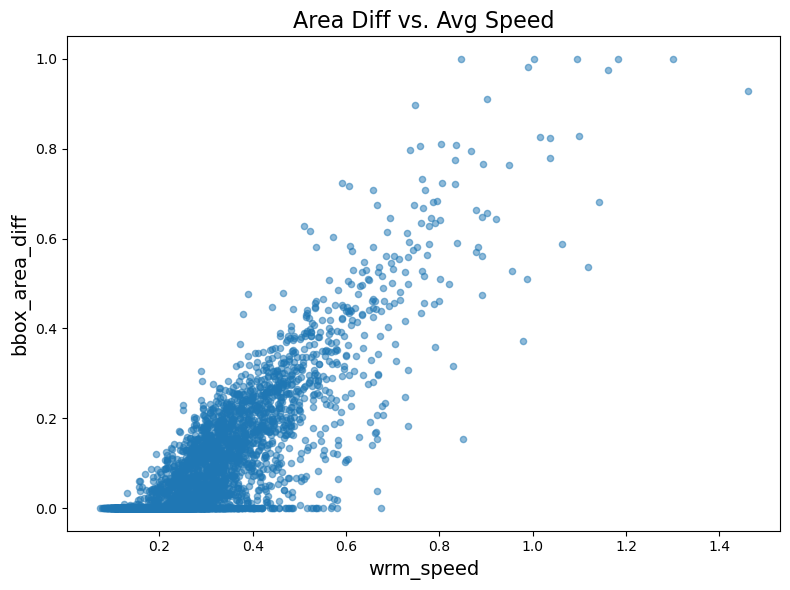

In [10]:
from evaluation.analysis import Plotter
plt = Plotter("logs2/bboxes.csv")
plt.plot_area_vs_speed()

In [ ]:
data = plt._data
mask = data['bbox_area_diff'] <= 0.2
data[mask].describe()

In [ ]:
plt._data = data[mask]
plt.plot_v1()

In [ ]:
import seaborn as sns
data = plt._data
data['wrm_speed_avg'] = data['wrm_speed'].rolling(window=5, center=True).mean()
ax = sns.scatterplot(data=plt._data, x='wrm_speed_avg', y='bbox_area_diff')
ax.set_xlim(0,10)

In [ ]:
cv.destroyAllWindows()
raise Exception("Finished")

In [ ]:
bbox = (360 - 360 // 2, 2348 - 360 // 2, 25, 13)
mask = extractor.find_worm(15, (0, 0, 10000, 10000))

In [ ]:
np.sum(mask != 0)

In [ ]:
np.sum(mask == 1)

In [ ]:
colored = cv.cvtColor(mask * 255, cv.COLOR_GRAY2BGR)
cv.imshow("mask", colored)
cv.waitKey(0)

In [1]:
from evaluation.simulator import *
from evaluation.sim_controllers import *
from utils.path_utils import Files

time_config = TimingConfig(
    frames_per_sec=60,
    imaging_time_ms=200,
    pred_time_ms=40,
    moving_time_ms=50,
    px_per_mm=90,
    camera_size_mm=(4, 4),
    micro_size_mm=(0.225, 0.225),
    init_position=(1300,1200),
    frame_padding_value=(255, 255, 255),
)

log_config = LogConfig(
    root_folder="logs2/",
    save_mic_view=False,
    save_cam_view=False,
    save_err_view=False,
)

yolo_config = YoloConfig(
    model_path="yolov8m-trained.pt",
    verbose=True,
)

log_config.create_dirs()


""" time_config.save_json("logs/time_config.json")
log_config.save_json("logs/log_config.json")
yolo_config.save_json("logs/yolo_config.json") """


""" frames_path = "Archive/"
files = Files(frames_path, extension="Bmp", sorting_key=lambda f: int(f.split("-")[-1].split(".")[0]))
files_list = [file for file in files]
reader = FrameReader(frames_path, files_list) """

reader = FrameReader.create_from_directory("/mnt/c/Users/freid/Desktop/eval/micro")

""" time_config = TimingConfig.load_json("logs/time_config.json")
log_config = LogConfig.load_json("logs/log_config.json")
yolo_config = YoloConfig.load_json("logs/yolo_config.json") """

' time_config = TimingConfig.load_json("logs/time_config.json")\nlog_config = LogConfig.load_json("logs/log_config.json")\nyolo_config = YoloConfig.load_json("logs/yolo_config.json") '

In [ ]:
print(time_config.imaging_frame_num + time_config.moving_frame_num)

In [2]:
#sim_controller = YoloController(time_config, yolo_config)
sim_controller = CsvController(time_config, "logs/bboxes.csv")
log_controller = LoggingController(sim_controller, log_config)
sim = Simulator(time_config, reader, log_controller)

In [3]:
sim.run(visualize=False)

Simulation Progress:   0%|          | 0/4080 [00:00<?, ?cycle/s]

In [ ]:
cv.destroyAllWindows()
raise Exception("Finished")

In [ ]:
from frame_reader import FrameReader

reader = FrameReader.create_from_directory("Archive/")

In [ ]:
from dataset.create.box_calculator import BoxCalculator
from dataset.create.sample_extractor import SampleExtractor

bbox_calc = BoxCalculator(reader)
extractor = SampleExtractor(bbox_calc)
extractor.create_all_samples(target_size=(400, 400), save_folder="samples")